(example-htn-to-2d)=

# Converting a hyper TN for approximate contraction

This example demonstrates how to convert a tensor network with hyper indices into A. a normal tensor network, with no assumptions about structure, and B. an actual [`TensorNetwork2D`](quimb.tensor.TensorNetwork2D) instance, that supports 2D specific manual approximate contraction schemes.

In [1]:
%config InlineBackend.figure_formats = ['svg']

import quimb as qu
import quimb.tensor as qtn

First we'll setup a pairwise interacting hyper tensor network, similar to a nearest neighbor classical partition function defined on a square lattice. Here sites are represented by indices, and the tensors are all 2D matrices that link neighboring sites.

In [2]:
Lx = 10
Ly = 11
qu.seed_rand(42)

edges = qtn.edges_2d_square(Lx, Ly, cyclic=True)
sites = sorted({coo for edge in edges for coo in edge})

# we'll need some convention for naming tags
site_tag_id = "I{},{}"
site_ind_id = "s{},{}"

htn = qtn.TensorNetwork()
for cooa, coob in edges:
    htn |= qtn.rand_tensor(
        # assume local dimension of size 2
        shape=[2, 2],
        inds=[site_ind_id.format(*cooa), site_ind_id.format(*coob)],
        tags=[site_tag_id.format(*cooa), site_tag_id.format(*coob)],
        # for contractbility use positive uniform distribution
        dist="uniform",
    )

If we draw the HTN you can see the layout, where each index connects four tensors, and each of those tensors is tagged with the two sites it joins:

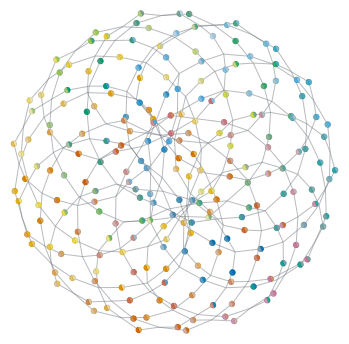

In [3]:
htn.draw(htn.tags, layout="neato")

## Fully automatic to general TN:

The following method works for arbitrary geometry, producing a standard [`TensorNetwork`](quimb.tensor.TensorNetwork), but with no guarantees on its structure, other than that there are no hyper indices.

First we 'resolve' each hyper index into an actual tensor (or optionally tensor network), using the [`hyperinds_resolve`](quimb.tensor.TensorNetwork.hyperinds_resolve) method:

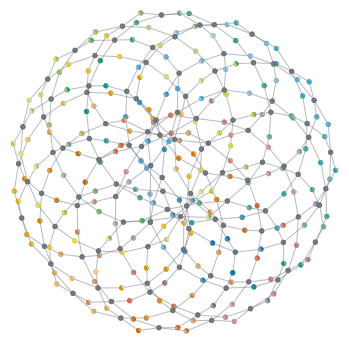

In [4]:
tn = htn.hyperinds_resolve()
tn.draw(tn.tags, layout="neato")

```{note}
There are many ways to resolve hyper indices, and especially if the hyper indices connect many tensors, the default choice of a single COPY tensor is not sensible. Another good choice is `hyperinds_resolve("tree", "clustering")`. On the other hand, when a lattice structure is present, and compressed contraction is the goal, a choice that maintains this structure generally helps the approximate contraction finder.
```

We can then ['rank_simplify'](quimb.tensor.TensorNetwork.rank_simplify) this TN, that is, perform any trivial contractions that don't involve creating larger rank tensors, this gives us a more compact network:

In [5]:
tn.rank_simplify_()

TensorNetwork(tensors=110, indices=220)

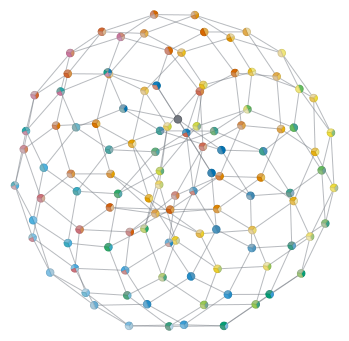

In [6]:
tn.draw(htn.tags, layout="neato")

The tags show you that some tensors have been formed from varying cluster of the original tensors.

```{hint}
There is also the experimental [`compress_simplify`](quimb.tensor.TensorNetwork.compress_simplify) method, which will combine rounds of hyper index resolution with various types of simplification. It generally has the best chance of reducing a networks size for *exact* contraction, and has a `final_resolve=True` option meaning it always outputs a non-hyper TN.
```

Once we have the TN in non-hyper form, we can contract it approximately using fully automatic approximate contraction (https://arxiv.org/abs/2206.07044):

In [7]:
import cotengra as ctg

# first we find a compressed specific contraction tree:
copt = ctg.HyperCompressedOptimizer(chi=16, progbar=True)
ctree = tn.contraction_tree(copt)

F=7.24 C=7.57 S=14.00 P=15.02: 100%|██████████| 128/128 [00:02<00:00, 44.60it/s]


Check cost of compressed tree first:

In [8]:
ctree.compressed_contract_stats()

<CompressedStatsTracker(F=7.24, C=7.57, S=14.00, P=15.02)>

The P value (peak memory), means storage for $2^{15.19}$ elements will be needed.

Then we can perform the compressed contraction:

In [9]:
tn.contract_compressed(ctree, progbar=True)

log2[SIZE]: 12.00/12.00:  51%|█████▏    | 56/109 [00:00<00:00, 1320.83it/s]

log2[SIZE]: 0.00/13.46: 100%|██████████| 109/109 [00:00<00:00, 700.63it/s] 


np.float64(3.931684265510081e-38)

`max_bond` will be picked up automatically from the `ctree`. There are also many other parameters controlling accuracy such as gauging, see the [`contract_compressed`](quimb.tensor.TensorNetwork.contract_compressed) docstring for more details.

## Manually to `TensorNetwork2D`

We know that the hyper TN we created has a 2D-like structure. The following demonstrates how to convert it no just to a non-hyper TN, but also setup the tag structure so that it can cast as a [`TensorNetwork2D`](quimb.tensor.tensor_2d.TensorNetwork2D). From then, 2D specific algorithms can be applied to it.

Here we'll first split each bond tensor in half:

In [10]:
tn = htn.copy()

site_tag_to_inds = {}

for cooa, coob in edges:
    # get the tensor at this bond
    taga = site_tag_id.format(*cooa)
    tagb = site_tag_id.format(*coob)
    t = tn.pop_tensor((taga, tagb))
    # we only want cooa tag on left, coob tag on right
    t.drop_tags((taga, tagb))

    # get ind to define left/right split
    lix = site_ind_id.format(*cooa)
    # name for the new bond
    bix = qtn.rand_uuid()
    tl, tr = t.split(
        left_inds=[lix],
        # how to split doesn't really matter, just do it exactly
        cutoff=0.0,
        get="tensors",
        ltags=taga,
        rtags=tagb,
        bond_ind=bix,
    )
    tn |= tl
    tn |= tr

    # record the bonds around each site for later contraction
    site_tag_to_inds.setdefault(taga, []).append(bix)
    site_tag_to_inds.setdefault(tagb, []).append(bix)

We now have two tensors per bond, and four tensors belonging exclusively to each site:

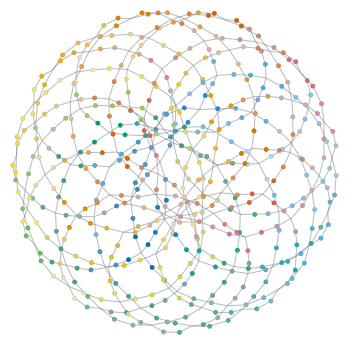

In [11]:
tn.draw(tn.tags, layout="neato")

We can now contract those four tensors, needing to specifiy the incident indices since it is an effect hyper contraction:

In [12]:
for tag, inds in site_tag_to_inds.items():
    tn.contract_(tag, output_inds=inds)

We now have a single tensor per site, correctly tagged for that site.

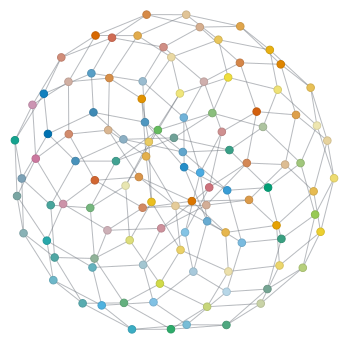

In [13]:
tn.draw(tn.tags, layout="neato")

Finally we want to cast the network as [`TensorNetwork2D`](quimb.tensor.tensor_2d.TensorNetwork2D), that involves adding some extra tags that specify the 2D stucture:

In [14]:
x_tag_id = "X{}"
y_tag_id = "Y{}"

for coo in sites:
    i, j = coo
    t = tn[site_tag_id.format(i, j)]
    t.add_tag((x_tag_id.format(i), y_tag_id.format(j)))

Before 'casting' the TN:

In [15]:
tn.view_as_(
    qtn.TensorNetwork2D,
    site_tag_id=site_tag_id,
    x_tag_id=x_tag_id,
    y_tag_id=y_tag_id,
    Lx=Lx,
    Ly=Ly,
)

TensorNetwork2D(tensors=110, indices=220, Lx=10, Ly=11, max_bond=2)

Now we can call 2D specific methods. For this PBC contraction for example, the two following methods (docstrings: [HOTRG](quimb.tensor.TensorNetwork2D.contract_hotrg) and [CTMRG](quimb.tensor.TensorNetwork2D.contract_ctmrg)) are supported:

In [16]:
tn.contract_hotrg(max_bond=8)

np.float64(3.931679435391318e-38)

In [17]:
tn.contract_ctmrg(max_bond=16)

np.float64(3.931773203487969e-38)